In [25]:
from river import stream,tree,metrics
import utils
import datetime
from encoding import prefix_bin
import csv
import copy
import time

In [47]:
dataset = stream.iter_csv(
            './data/bac_online_small.csv',
            )

totallength = len(list(dataset))

In [48]:
dataset = stream.iter_csv(
            './data/bac_online_small.csv',
            drop=['END_DATE','ROLE','CLOSURE_TYPE','CLOSURE_REASON','WORKING_STATE','case_cost'],
            target='outcome'
            )

**Event stream entry**  
----------  
**Example 1)**  
({'REQUEST_ID': '20175000168',  
  'ACTIVITY': 'Service closure Request with network responsibility',  
  'START_DATE': '2018-10-10 12:48:12.000',  
  'CE_UO': '1'},  
 '')  
   
**Example 2)**  
({'REQUEST_ID': '20175000168',  
  'ACTIVITY': 'Request completed with account closure',  
  'START_DATE': '2018-10-17 03:03:11.000',  
  'CE_UO': 'BOF'},  
 'False')

In [49]:
key_pair = {
        'REQUEST_ID':'caseid',
        'ACTIVITY':'activity',
        'START_DATE':'ts',
        'CE_UO':'resource'
}

case_dict ={}
training_models ={}
feature_matrix ={}
casecount = 0
rowcounter = 0
resultdict ={}
acc_dict ={}
finishedcases = set()
running_case = 0
prediction_result = {}

In [50]:
for x,y in dataset:
    if rowcounter%500 == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount), 'Running case: %s'%(running_case))
    rowcounter +=1
    # Event stream change dictionary keys
    x = utils.dictkey_chg(x, key_pair)
#     x['ts'] = x['ts'][:-4]
    # Check label possible
    # x = utils.set_label(x)
    x['outcome'] =y 
    # Initialize case by prefix length
    caseid = x['caseid']
    outcome = x['outcome']
#     progress = x['progress']

    x.pop('caseid')
    x.pop('outcome')
    
#     x.pop('progress')

    case_bin = prefix_bin(caseid, x)

    if caseid not in list(case_dict.keys()):
        case_bin.set_prefix_length(1)    
        case_dict[caseid] = []
        running_case +=1
    elif caseid in finishedcases:
        pass
    else:
        case_bin.set_prefix_length(len(case_dict[caseid])+1)
        case_bin.set_prev_enc(case_dict[caseid][-1])
    
    # Encode event and cases and add to DB
    case_bin.update_truelabel(outcome)   
    case_bin.update_encoded()
    ts = case_bin.event['ts']
    case_dict[caseid].append(case_bin)
    
    # Detect label appeared case 
    if outcome != '' and caseid not in finishedcases:
        finishedcases.add(caseid)
        # Adding newly finished case to training set.    
        casecount +=1
        # Grace period to collect feature matrix
        if casecount <200:
            case_length = len(case_dict[caseid])
            for prefix in range(1, case_length):
                if 'prefix_%s'%(prefix+1) not in list(feature_matrix.keys()):
                    feature_matrix['prefix_%s'%(prefix+1)]=set()
                    # Initialize classifier and performance matrix and updating count
                    training_models['prefix_%s'%(prefix+1)] = [tree.ExtremelyFastDecisionTreeClassifier(grace_period=100,split_criterion='info_gain'),metrics.Accuracy(), 0]
                feature_list = list(case_dict[caseid][prefix].encoded.keys())
                for x in feature_list: feature_matrix['prefix_%s'%(prefix+1)].add(x) 
            case_dict.pop(caseid)               

        # Real training start
        else:
            # Modify encoded attributes of cases with feature matrix
            case_length = len(case_dict[caseid])
            if case_length >10:
                case_length =10
            y = outcome
            for prefix in range(1, case_length):
                case_dict[caseid][prefix].update_truelabel(y)
                if case_dict[caseid][prefix].grace_updated == False:
                    case_dict[caseid][prefix].encoded = utils.readjustment_training(case_dict[caseid][prefix].encoded, feature_matrix['prefix_%s'%(prefix+1)])
                    case_dict[caseid][prefix].update_grace_status(True)
                x = case_dict[caseid][prefix].encoded
                model = training_models['prefix_%s'%(prefix+1)][0]
                model.learn_one(x,y)
                training_models['prefix_%s'%(prefix+1)][2] +=1
                y_pred = model.predict_one(x)
                training_models['prefix_%s'%(prefix+1)][1].update(y,y_pred)

                for cases in list(case_dict.keys()):
                    if len(case_dict[cases]) >prefix:
                        if case_dict[cases][prefix].grace_updated ==False:
                            case_dict[cases][prefix].encoded = utils.readjustment_training(case_dict[cases][prefix].encoded, feature_matrix['prefix_%s'%(prefix+1)])
                            case_dict[cases][prefix].update_grace_status(True)
                        x_test = case_dict[cases][prefix].encoded
                        y_pred = model.predict_one(x_test)
                        modelid,pred_value = copy.deepcopy(training_models['prefix_%s'%(prefix+1)][2]), copy.deepcopy(y_pred)
                        case_dict[cases][prefix].update_prediction((modelid, pred_value))
                        prediction_key = str(cases)+'_'+str(prefix+1)
                        if str(cases)+'_'+str(prefix+2) not in prediction_result.keys():
                            if prediction_key not in prediction_result.keys():
                                prediction_result[prediction_key] = {}
                                prediction_result[prediction_key][modelid] = (pred_value,ts)
                            else:
                                prediction_result[prediction_key][modelid] = (pred_value,ts)
            copying = copy.deepcopy(case_dict[caseid])
            resultdict[caseid] = copying
            case_dict[caseid] =[]
            running_case -=1
            for prefix in training_models.keys():
                if prefix not in list(acc_dict.keys()):
                    acc_dict[prefix]=[training_models[prefix][1].get()]
                else:
                    acc_dict[prefix].append(training_models[prefix][1].get())


0.0 % Case finished: 0 Running case: 0
1.65 % Case finished: 5 Running case: 159
3.3 % Case finished: 5 Running case: 317
4.95 % Case finished: 5 Running case: 426
6.6 % Case finished: 37 Running case: 534
8.25 % Case finished: 55 Running case: 592
9.9 % Case finished: 217 Running case: 613
11.55 % Case finished: 304 Running case: 588
13.2 % Case finished: 395 Running case: 567
14.85 % Case finished: 478 Running case: 556
16.5 % Case finished: 564 Running case: 537
18.16 % Case finished: 653 Running case: 530
19.81 % Case finished: 738 Running case: 516
21.46 % Case finished: 789 Running case: 576
23.11 % Case finished: 831 Running case: 637
24.76 % Case finished: 841 Running case: 680
26.41 % Case finished: 1022 Running case: 538
28.06 % Case finished: 1112 Running case: 508
29.71 % Case finished: 1167 Running case: 527
31.36 % Case finished: 1255 Running case: 506
33.01 % Case finished: 1360 Running case: 467
34.66 % Case finished: 1438 Running case: 469
36.31 % Case finished: 1550 R

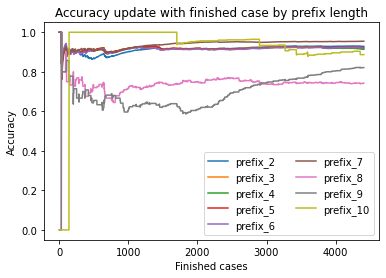

In [56]:
import matplotlib.pyplot as plt
for t in list(acc_dict.keys())[:9]:
    plt.plot(acc_dict[t], label=str(t))
    plt.legend(ncol=2,loc='lower right')
plt.title('Accuracy update with finished case by prefix length')
plt.ylabel('Accuracy')
plt.xlabel('Finished cases')
plt.show()

In [52]:
for m in training_models.keys():
    print(m, training_models[m][2])

prefix_2 4410
prefix_3 3973
prefix_4 3953
prefix_5 3948
prefix_6 3765
prefix_7 3377
prefix_8 417
prefix_9 246
prefix_10 53
prefix_11 0
prefix_12 0
prefix_13 0
prefix_14 0
prefix_15 0


In [69]:
for t in sorted(prediction_result.keys()):
    caseid = t.split('_')[0]
    prefix = t.split('_')[1]
    if caseid == '201710001376':
        print(t,resultdict['201710001376'][int(prefix)-1].event['ts'],prediction_result[t])
        print('----------')
    
    
# checklist= {}
# for t in sorted(prediction_result.keys()):
# #     if int(t.split('_')[0]) ==201710000981:
#     checklist[int(t.split('_')[1])] = []
# for t in sorted(prediction_result.keys()):
#     timelist = [x[1] for x in prediction_result[t].values()]
#     checklist[int(t.split('_')[1])].append(len(timelist))
# #     print(e,min(timelist), max(timelist), len(timelist))
# # for e in sorted(prediction_result.keys())[-100:]:
# #     print(e,prediction_result[e])

# for k in sorted(checklist.keys()):
#     print(k, max(checklist[k]), min(checklist[k]))
# # print(checklist)

201710001376_2 2017-10-05 11:49:48 {1: ('False', datetime.datetime(2018, 9, 14, 3, 45, 21)), 2: ('False', datetime.datetime(2018, 9, 14, 3, 45, 51)), 3: ('False', datetime.datetime(2018, 9, 14, 3, 46, 51)), 4: ('False', datetime.datetime(2018, 9, 14, 3, 48, 34)), 5: ('False', datetime.datetime(2018, 9, 14, 3, 49, 13)), 6: ('False', datetime.datetime(2018, 9, 14, 3, 49, 18)), 7: ('False', datetime.datetime(2018, 9, 14, 3, 49, 36)), 8: ('False', datetime.datetime(2018, 9, 14, 3, 50, 18)), 9: ('False', datetime.datetime(2018, 9, 14, 3, 50, 30)), 10: ('False', datetime.datetime(2018, 9, 14, 3, 53, 27)), 11: ('False', datetime.datetime(2018, 9, 14, 3, 56, 7)), 12: ('False', datetime.datetime(2018, 9, 14, 3, 56, 16)), 13: ('False', datetime.datetime(2018, 9, 14, 3, 56, 27)), 14: ('False', datetime.datetime(2018, 9, 14, 3, 58, 6)), 15: ('False', datetime.datetime(2018, 9, 14, 3, 58, 14)), 16: ('False', datetime.datetime(2018, 9, 14, 4, 0, 27)), 17: ('False', datetime.datetime(2018, 9, 14, 4, 

In [40]:
for case in list(resultdict.keys())[:10]:
    print(resultdict[case][-1].event['ts'],resultdict[case][-2].event['ts'])
    

2018-09-14 03:47:45 2018-09-12 14:32:02
2018-09-14 03:48:42 2018-09-12 10:03:57
2018-09-14 03:49:00 2018-09-12 11:23:57
2018-09-14 03:49:13 2018-09-12 12:03:51
2018-09-14 03:49:36 2018-09-12 09:12:10
2018-09-14 03:49:40 2018-09-12 11:43:55
2018-09-14 03:49:54 2018-09-12 11:03:50
2018-09-14 03:49:59 2018-09-12 15:23:50
2018-09-14 03:50:30 2018-09-12 10:07:48
2018-09-14 03:52:55 2018-09-12 10:59:59


In [33]:
import numpy as np
from sklearn.metrics import classification_report
for t in range(2,11):
    testcases =[]
    testpred = []
    testtrue = []

    print('prefix_%s'%(t))
    for cases in (np.random.choice(list(resultdict.keys()), 1500)):
        if len(resultdict[cases])>t:
            y_pred = training_models['prefix_%s'%(t+1)][0].predict_one(resultdict[cases][t].encoded)
            testpred.append(y_pred)
            testtrue.append(resultdict[cases][t].true_label)
    metric = metrics.Accuracy()
    cm = metrics.ConfusionMatrix()
    for yt,yp in zip(testtrue,testpred):
        metric = metric.update(yt,yp)
        cm = cm.update(yt,yp)
    print(metric)
    print(cm)
    print(classification_report(testtrue,testpred))

prefix_2
Accuracy: 90.77%
           False    True
   False    1229      21
    True     105      10
              precision    recall  f1-score   support

       False       0.92      0.98      0.95      1250
        True       0.32      0.09      0.14       115

    accuracy                           0.91      1365
   macro avg       0.62      0.54      0.54      1365
weighted avg       0.87      0.91      0.88      1365

prefix_3
Accuracy: 89.53%
           False    True
   False    1224      20
    True     124       8
              precision    recall  f1-score   support

       False       0.91      0.98      0.94      1244
        True       0.29      0.06      0.10       132

    accuracy                           0.90      1376
   macro avg       0.60      0.52      0.52      1376
weighted avg       0.85      0.90      0.86      1376

prefix_4
Accuracy: 92.49%
           False    True
   False    1253      12
    True      91      15
              precision    recall  f1-score

c:\python3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


TypeError: '<' not supported between instances of 'NoneType' and 'str'